In [1]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#!pip install lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_players = pd.read_csv('df_players.csv')

In [154]:
#make model for batting
df_players_pitching = df_players[df_players['primary_position'] == 'p']

In [156]:
df_players_pitching.columns

Index(['Unnamed: 0', 'player_mlb_id', 'playerID_LAHMAN', 'birthYear',
       'birthMonth', 'birthDay', 'birthCountry', 'weight', 'height', 'bats',
       ...
       'avg_bf_per_outing', 'zone_chase_pct', 'total_runs',
       'batter_avg_exp_ba', 'pitcher_avg_exp_ba', 'primary_position', 'sp_pct',
       'age', 'years_before_26', 'years_after_28'],
      dtype='object', length=184)

In [158]:
current_pitcher_features = [
    'player_mlb_id',
    'year',
    'years_after_28',
    'throws',
    'whip',
    'baa',
    'sp_pct',
    'k_rate_pitcher',
    'bb_rate_pitcher',
    'inplay_ratio_pitcher',
    'batter_avg_exp_ba',
    'babip_pitcher',
    'fly_balls_ratio_pitcher',
    'ground_balls_ratio_pitcher',
    'line_drives_ratio_pitcher',
    'popups_ratio_pitcher',
    'hr_fb_pct_pitcher',
    'avg_bf_per_outing',
    'zone_chase_pct',
    'avg_fb_vel',
    'total_bf'
    #regress stats based on 50 league average plate appearances
]

Get averages per year

In [161]:
df_players_pitching = df_players_pitching[current_pitcher_features]

In [163]:
df_players_pitching['starter'] = (df_players_pitching['sp_pct'] > 50).astype(int)

In [165]:
df_players_pitching_means = df_players_pitching[df_players_pitching['total_bf'] > 1]

#select numeric columns and columns needed for groupby
numeric_cols = df_players_pitching_means.select_dtypes(include=np.number).columns.tolist()
df_players_pitching_means = df_players_pitching_means[numeric_cols]

#get means
weighted_means_position = df_players_pitching_means.groupby(['year', 'starter']).apply(
    lambda group: group.apply(
        lambda col: np.average(col.dropna(), weights=group.loc[col.dropna().index, 'total_bf']) 
        if col.name != 'total_bf' and group.loc[col.dropna().index, 'total_bf'].sum() > 0
        else col.mean(),  # Use col.mean() for total_bf column
        axis=0
    )
)
weighted_means_position = weighted_means_position.drop(columns=['starter','year']).reset_index()

Back to model

In [168]:
df_players_pitching.isna().sum()

player_mlb_id                    0
year                             0
years_after_28                   0
throws                           0
whip                          1001
baa                            998
sp_pct                           0
k_rate_pitcher                 998
bb_rate_pitcher                998
inplay_ratio_pitcher           998
batter_avg_exp_ba             2943
babip_pitcher                  998
fly_balls_ratio_pitcher       1039
ground_balls_ratio_pitcher    1014
line_drives_ratio_pitcher     1040
popups_ratio_pitcher          1202
hr_fb_pct_pitcher             1039
avg_bf_per_outing              998
zone_chase_pct                 998
avg_fb_vel                    1095
total_bf                         0
starter                          0
dtype: int64

In [170]:
# Set the index for easier mapping
weighted_means_dict = weighted_means_position.set_index(['year', 'starter']).to_dict(orient='index')

# Function to fill NaNs using weighted means
def fill_with_weighted_means(row):
    key = (row['year'], row['starter'])
    if key in weighted_means_dict:
        for col in weighted_means_dict[key]:
            if pd.isna(row[col]):  # Fill NaN only
                row[col] = weighted_means_dict[key][col]
    return row

# Apply the function
df_players_pitching = df_players_pitching.apply(fill_with_weighted_means, axis=1)

# Replace any remaining NaNs with 0
df_players_pitching.fillna(0, inplace=True)


In [172]:
#avoid infinite values
df_players_pitching.replace(np.inf, 1, inplace=True)

In [174]:
# Ensure it's a DataFrame and reset the index properly
weighted_means_position = pd.DataFrame(weighted_means_position).reset_index()
weighted_means_position.replace(np.inf, 1, inplace=True)

In [176]:
df_pitching_w_relative = df_players_pitching.merge(weighted_means_position, on=['year','starter'], how='left', suffixes=('','_rel'))

In [178]:
# Iterate over all columns
for col in df_pitching_w_relative.columns:
    # Check if column ends with '_rel'
    if col.endswith('_rel'):
        # Create the name of the corresponding column without '_rel'
        original_col = col[:-4]  # Remove the '_rel' suffix
        if original_col in df_pitching_w_relative.columns:
            # Subtract the original column from the '_rel' column and assign it back
            df_pitching_w_relative[col] = (df_pitching_w_relative[original_col] / df_pitching_w_relative[col])*100

In [180]:
df_2021 = df_pitching_w_relative[df_pitching_w_relative['year'] == 2021]
df_2022 = df_pitching_w_relative[df_pitching_w_relative['year'] == 2022]
df_2023 = df_pitching_w_relative[df_pitching_w_relative['year'] == 2023][['player_mlb_id','total_bf','years_after_28','throws','starter']]
df_all = df_2021.merge(df_2022, on='player_mlb_id', how='outer', suffixes=("_2ya","_1ya")).drop(columns=['year_2ya','year_1ya'])
df_all = df_all.merge(df_2023, on='player_mlb_id',how='outer').drop(columns='player_mlb_id')

In [182]:
df_all['total_bf_avg'] = df_all['total_bf_1ya']*.6 + df_all['total_bf_2ya']*.4

In [184]:
df_all.drop(columns='batter_avg_exp_ba_rel_1ya', inplace=True)

In [186]:
# #fill in empty columns for batting hand
# df_50['bats'] = df_50['bats'].fillna(df_50['bats_1ya']).fillna(df_50['bats_2ya'])

# #fill in empty ages/years after debut for players
# df_50['age'] = df_50['age'].fillna(df_50['age_1ya'] + 1).fillna(df_50['age_2ya'] + 2)
# df_50['years_before_26'] = df_50['years_before_26'].fillna(df_50['years_before_26_1ya'] + 1).fillna(df_50['years_before_26_2ya'] + 2)
# df_50['years_after_28'] = df_50['years_after_28'].fillna(df_50['years_after_28_1ya'] + 1).fillna(df_50['years_after_28_2ya'] + 2)
# df_50 = df_50.drop(columns=['age_1ya','age_2ya','years_before_26_1ya','years_before_26_2ya','years_after_28_1ya','years_after_28_2ya','bats_1ya','bats_2ya','primary_position_2ya','primary_position_1ya'])

# #for players who didn't play, set batting position to other year or the min for the year.
# df_50['avg_lineup_position_1ya'] = df_50['avg_lineup_position_1ya'].fillna(df_50['avg_lineup_position_2ya']).fillna(df_50['avg_lineup_position_1ya'].max())
# df_50['avg_lineup_position_2ya'] = df_50['avg_lineup_position_2ya'].fillna(df_50['avg_lineup_position_1ya'])

In [189]:
df_all = df_all[(df_all['total_bf_2ya']>0) & (df_all['total_bf_1ya']>0)]

In [191]:
# for col in df_batting_simp.isna().sum().index:
#     print(f"{col}: {df_batting_simp[col].isna().sum()}")

In [193]:
#split starters and relievers
df_starters = df_all[df_all['starter'] == 1]
df_relievers = df_all[df_all['starter'] == 0]

In [195]:
#limit columns in df_all
pitching_cols = ['total_bf_1ya', 'total_bf_avg', 'total_bf_2ya', 'inplay_ratio_pitcher_rel_1ya', 'inplay_ratio_pitcher_rel_2ya', 
                 'sp_pct_2ya', 'sp_pct_1ya', 'baa_rel_1ya', 'baa_rel_2ya', 'avg_bf_per_outing_1ya', 'avg_bf_per_outing_2ya',
                 'whip_rel_2ya', 'whip_rel_1ya', 'zone_chase_pct_rel_1ya', 'zone_chase_pct_rel_2ya','starter', 'total_bf'
                ]
df_starters = df_starters[pitching_cols]
df_relievers = df_relievers[pitching_cols]

In [197]:
X = df_starters.drop(columns='total_bf')
y = df_starters['total_bf']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [201]:
# Scale features
numeric_cols = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [203]:
#convert categorical data
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [205]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 21%|██▏       | 9/42 [00:01<00:04,  7.79it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 98%|█████████▊| 41/42 [00:05<00:00,  5.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 132, number of used features: 15
[LightGBM] [Info] Start training from score 402.181818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

100%|██████████| 42/42 [00:06<00:00,  6.67it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoLarsCV                                 -0.17       0.17 249.41   
LassoLars                                   -0.17       0.17 249.41   
LarsCV                                      -0.17       0.17 249.64   
LassoLarsIC                                 -0.17       0.16 249.82   
LassoCV                                     -0.17       0.16 250.25   
AdaBoostRegressor                           -0.18       0.16 251.13   
TweedieRegressor                            -0.19       0.15 252.21   
ElasticNet                                  -0.19       0.15 252.35   
ElasticNetCV                                -0.20       0.15 252.70   
BayesianRidge                               -0.20       0.14 253.06  

In [55]:
#try with simple model

In [207]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize the ElasticNetCV model (with 10-fold cross-validation)
elastic_net = ElasticNetCV(cv=10, random_state=42, alphas=np.logspace(-4, 4, 100), l1_ratio=0.5)

# Fit the ElasticNetCV model to the training data
elastic_net.fit(X_train, y_train)

# Get the best alpha and L1 ratio from cross-validation
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_
print(f"Best alpha: {best_alpha}")
print(f"Best L1 ratio: {best_l1_ratio}")

# Predict the target on the test set
y_pred = elastic_net.predict(X_test)

# Ensure that the predicted values are non-negative (e.g., for a count variable like 'PA')
y_pred = np.maximum(y_pred, 0)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Best alpha: 0.6280291441834259
Best L1 ratio: 0.5
Root Mean Squared Error (RMSE): 252.7793
R² Score: 0.1449


                         Feature  Coefficient  Abs_Coefficient
3   inplay_ratio_pitcher_rel_1ya       -49.57            49.57
0                   total_bf_1ya        48.34            48.34
7                    baa_rel_1ya       -41.11            41.11
1                   total_bf_avg        36.98            36.98
12                  whip_rel_1ya       -35.04            35.04
13        zone_chase_pct_rel_1ya        29.75            29.75
8                    baa_rel_2ya        23.60            23.60
11                  whip_rel_2ya        21.31            21.31
5                     sp_pct_2ya        13.74            13.74
6                     sp_pct_1ya        13.74            13.74
4   inplay_ratio_pitcher_rel_2ya        13.40            13.40
10         avg_bf_per_outing_2ya        12.11            12.11
14        zone_chase_pct_rel_2ya       -10.32            10.32
2                   total_bf_2ya         7.80             7.80
9          avg_bf_per_outing_1ya         0.00          

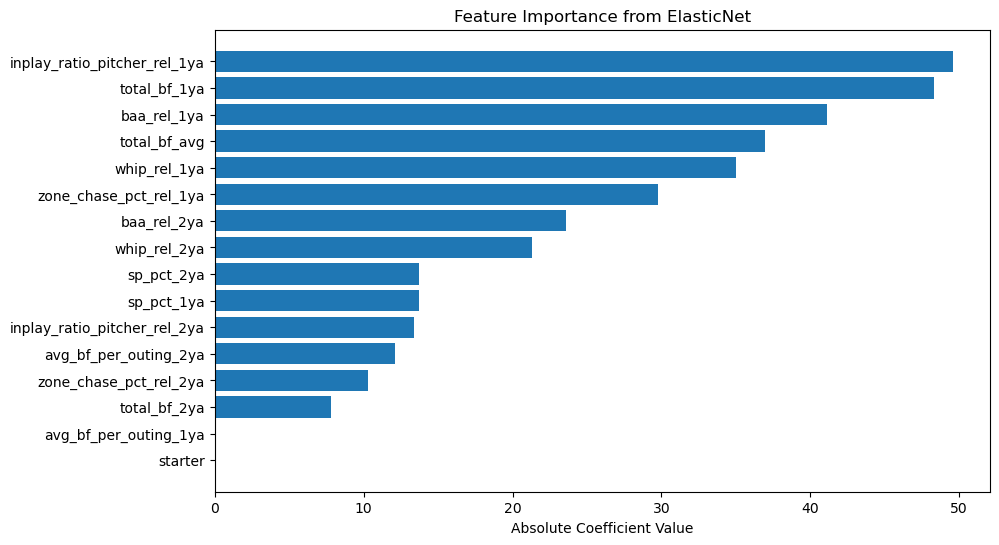

In [209]:
coefficients = elastic_net.coef_

# Create a DataFrame for the coefficients to associate with feature names
# After scaling, the feature names are lost, so we use the columns from X
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Use the original feature names from X
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Print the feature importance
print(feature_importance.head(20))

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from ElasticNet')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

In [211]:
print("\nActual vs Predicted Values:")
print(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head(20))  # Show first 20 rows


Actual vs Predicted Values:
      Actual  Predicted
1050      33     324.74
938      281     439.14
131      794     437.36
121        0     366.20
379      564     127.00
594      220     413.90
266       51     427.47
419      223     460.39
123        0     250.72
759      188     316.54
345      267     557.71
695      770     551.48
251      625     308.75
900        0     266.82
326      155     524.09
377        0     209.43
617       79     404.15
912      755     481.51
209      216     426.64
646      822     675.31


In [217]:
df_starters.loc[377]

total_bf_1ya                   194.00
total_bf_avg                   194.80
total_bf_2ya                   196.00
inplay_ratio_pitcher_rel_1ya   107.78
inplay_ratio_pitcher_rel_2ya   117.14
sp_pct_2ya                      64.00
sp_pct_1ya                      64.00
baa_rel_1ya                    116.17
baa_rel_2ya                    111.22
avg_bf_per_outing_1ya           10.27
avg_bf_per_outing_2ya            9.55
whip_rel_2ya                   110.39
whip_rel_1ya                   116.43
zone_chase_pct_rel_1ya         100.30
zone_chase_pct_rel_2ya         101.60
starter                          1.00
total_bf                         0.00
Name: 377, dtype: float64